#  ARMA learning and prediction with a Kalman filter

In [2]:
import ssm

In [319]:
import pandas as pd
import numpy as np

In [320]:
import jax
import chex
import einops
import seaborn as sns
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial
from jax.scipy.linalg import block_diag

In [321]:
%config InlineBackend.figure_format = "retina"

sns.set_palette("colorblind")
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["font.size"] = 12
# plt.rcParams["figure.figsize"] = (7.2, 4.0)
plt.rcParams["figure.figsize"] = (7.2, 3.0)

jnp.set_printoptions(linewidth=200)

In [322]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## The Kalman filter and predictions

In [323]:
@partial(jax.jit, static_argnames=("k",))
def forecast_mean(F, mu, k):
    """
    Following Proposition 2.2 in F.02
    """
    def _step(mu, _):
        mu_next = F @ mu
        return mu_next, mu_next
    steps = jnp.arange(k)
    _, mu_pred = jax.lax.scan(_step, mu, steps)
    return mu_pred


@partial(jax.jit, static_argnames=("k",))
def forecast_cov(F, Sigma, Q, k):
    """
    Following Proposition 2.3 in F.02
    """
    def _step(state, _):
        Sigma_mult, dynamics_carry, F_mult = state

        dynamics_carry = dynamics_carry + F_mult @ Q @ F_mult.T
        F_mult = F @ F_mult        
        Sigma_mult = F @ Sigma_mult @ F.T

        Sigma_pred = Sigma_mult + dynamics_carry
        
        state_next = (Sigma_mult, dynamics_carry, F_mult)
        return state_next, Sigma_pred
    steps = jnp.arange(k)
    dim_state = len(Q)
    state_init = (Sigma, jnp.zeros((dim_state, dim_state)), F)
    _, Sigma_pred = jax.lax.scan(_step, state_init, steps)
    return Sigma_pred

In [324]:
def kf_step_optimal(bel, y, H, F, R, Q, n_forecast):
    mu, Sigma = bel

    # Predict
    mu_pred = F @ mu
    Sigma_pred = F @ Sigma @ F.T + Q

    # innovation
    S = H @ Sigma_pred @ H.T + R
    K = jnp.linalg.solve(S, H @ Sigma_pred).T
    err =  y - H @ mu_pred # innovation

    # Update
    mu_update = mu_pred + K @ err
    Sigma_update = Sigma_pred - K @ S @ K.T
    bel_next = (mu_update, Sigma_update)

    out = {
        "mu": mu_update,
        "err": err,
        "yhat": H @ mu_pred,
        "y_corrected": H @ mu_update,
    }

    return bel_next, out

## Defining the ARMA process

In [325]:
key = jax.random.PRNGKey(3141)
key_sample, key_train = jax.random.split(key)

In [9]:
ma_n = 10
H_ma = jnp.ones(10) * 1.
H_ar = jnp.ones(3) * jnp.zeros(3).at[0].set(0.8)
H, F, T = ssm.init_arma_components(H_ma=H_ma)
dim_state = len(H)
# R = jnp.eye(1) * 1.0 ** 2
R = jnp.eye(1) * 1.0 ** 2

In [347]:
n_steps = 200
n_test = 20
steps = jnp.arange(n_steps)
sample = ssm.sample_ssm(key_sample, F, H, T, R, n_steps + n_test)

test = jax.tree.map(lambda x: x[-n_test:], sample)
sample = jax.tree.map(lambda x: x[:-n_test], sample)

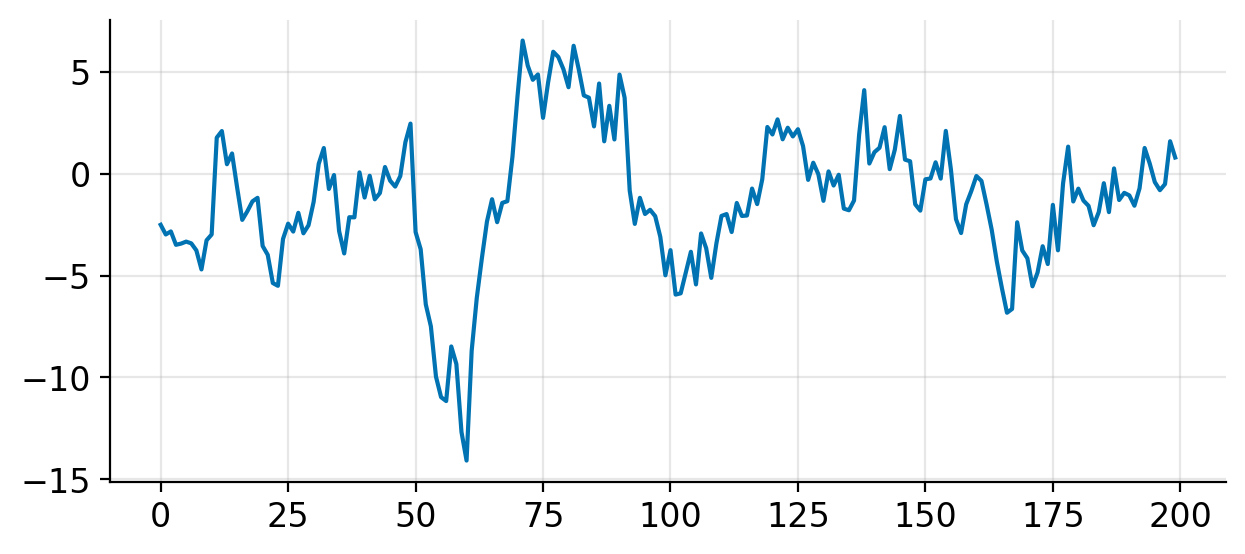

In [348]:
plt.plot(sample["y"])
plt.grid(alpha=0.3)

In [349]:
Q = T @ R @ T.T
n_forecast = 10
_step = partial(kf_step_optimal, H=H[None, :], F=F, R=R, Q=Q, n_forecast=n_forecast)
y = sample["y"]

mu_init = jnp.zeros(dim_state)
Sigma_init = jnp.eye(dim_state)
bel_init = (mu_init, Sigma_init)

(mu, Sigma), hist_optimal = jax.lax.scan(_step, bel_init, y[:, None])
hist_optimal = jax.tree.map(jnp.squeeze, hist_optimal)

In [350]:
filter_hist = jnp.einsum("i,ti->t", H, hist_optimal["mu"])

In [351]:
jnp.sqrt(jnp.power(hist_optimal["err"], 2).mean())

Array(1.6525016, dtype=float32)

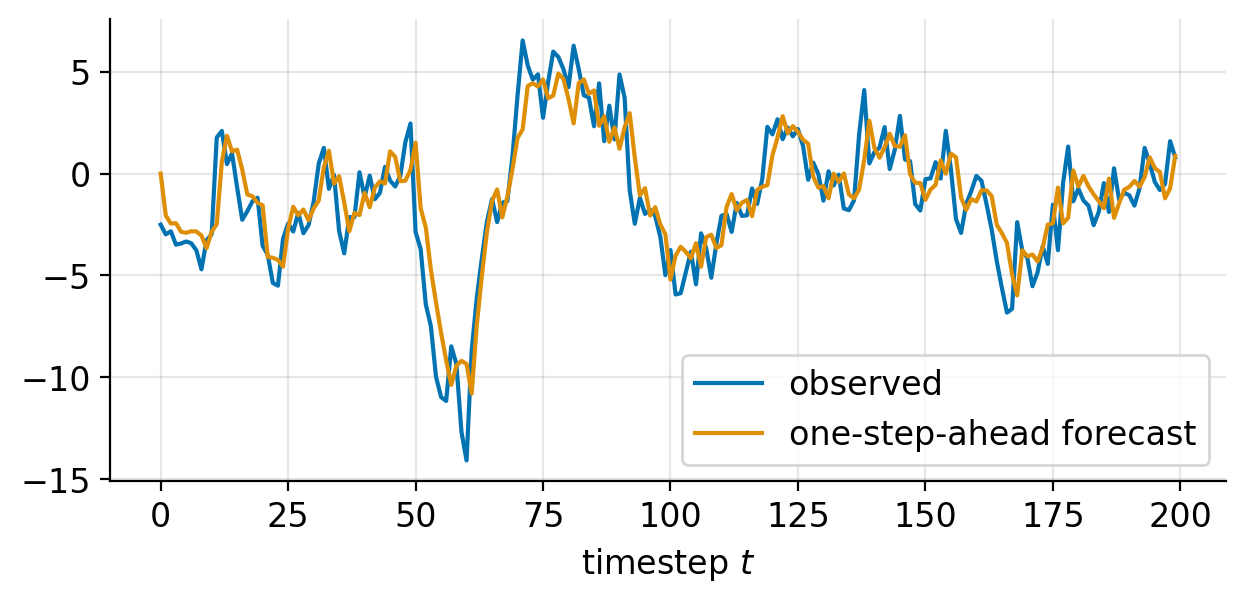

In [352]:
markersize = 0
plt.plot(sample["y"], marker="o", markersize=markersize, label="observed")
plt.plot(hist_optimal["yhat"], marker="o", markersize=markersize, label="one-step-ahead forecast")
plt.legend()
plt.xlabel("timestep $t$")
plt.grid(alpha=0.3)

## Learning and filtering

In [353]:
@chex.dataclass
class SSMConfig:
    """
    Known components of the SSM
    """
    F: jax.Array
    R: jax.Array
    Q: jax.Array
    latent_dim: jax.Array

@chex.dataclass
class KFState:
    mean: jax.Array
    cov: jax.Array
    dim: int

    @staticmethod
    def init(key, dim, cov_coeff, cov_latent):
        key_latent, key_coeff = jax.random.split(key)
        mean_latent = jax.random.normal(key_latent, (dim,)) * jnp.sqrt(cov_latent)
        mean_coeff = jax.random.normal(key_coeff, (dim,)) * jnp.sqrt(cov_coeff)
        mean_init = jnp.concat([mean_coeff, mean_latent])
        
        cov_coeff_init = jnp.eye(dim) * cov_coeff
        cov_latent_init = jnp.eye(dim) * cov_latent
        cov_init = jnp.zeros((2 * dim, 2 * dim))
        cov_init = cov_init.at[:dim, :dim].set(cov_coeff_init)
        cov_init = cov_init.at[dim:, dim:].set(cov_latent_init)
        
        return KFState(mean=mean_init, cov=cov_init, dim=dim)

    def mean_coeff(self, dim):
        return jax.lax.dynamic_slice_in_dim(self.mean, 0, dim)
        # return self.mean[:self.dim]

    def mean_latent(self, dim):
        return jax.lax.dynamic_slice_in_dim(self.mean, dim, dim)
        # return self.mean[self.dim:]

    def build_feature_and_bias(self, dim):
        """
        Obtain feature matrix and bias term for the online AR
        """
        mean_latent = self.mean_latent(dim)
        mean_coeff = self.mean_coeff(dim)
        # Estimated coefficient matrix
        H = jnp.r_[mean_latent, mean_coeff][None, :]
        bias = -mean_coeff.T @ mean_latent
        return H, bias

    
    def build_feature(self, dim):
        mean_latent = self.mean_latent(dim)
        mean_coeff = self.mean_coeff(dim)
        H = jnp.r_[mean_latent, mean_coeff][None, :]
        return H

    
    def predict(self, bel_pred, dim):
        """
        Predict next observation given mean vector
        """
        # H, bias = self.build_feature_and_bias(dim)
        # yhat = H @ mean + bias
        vcoeff = bel_pred.mean_coeff(dim)
        vlatent = bel_pred.mean_latent(dim)
        
        mean_latent = self.mean_latent(dim)
        mean_coeff = self.mean_coeff(dim)
        
        yhat = mean_coeff.T @ mean_latent + mean_coeff.T @ (vlatent - mean_latent) + mean_latent.T @ (vcoeff - mean_coeff)
        
        
        return yhat

In [354]:
def kf_step_inner(bel, bel_pred, y, ssm):
    """
    Inner iteration of the Iterated Kalman Filter
    """
    mu_pred = bel_pred.mean
    Sigma_pred = bel_pred.cov

    # H, bias = bel.build_feature_and_bias(ssm.latent_dim)
    # yhat = H @ mu_pred + bias
    
    H = bel.build_feature(ssm.latent_dim)
    yhat = bel.predict(bel_pred, ssm.latent_dim)

    # innovation
    S = H @ Sigma_pred @ H.T + ssm.R
    K = jnp.linalg.solve(S, H @ Sigma_pred).T
    err =  y - yhat

    # Update
    mu_update = mu_pred + K @ err
    Sigma_update = Sigma_pred - K @ S @ K.T
    
    bel = bel.replace(
        mean=mu_update,
        cov=Sigma_update
    )
    return bel


def kf_step_lin(bel, y, ssm, n_inner=1):
    """
    Iterated Kalman filter
    """
    # Predict
    mu_pred = ssm.F @ bel.mean
    Sigma_pred = ssm.F @ bel.cov @ ssm.F.T + Q

    bel_pred = bel.replace(
        mean=mu_pred,
        cov=Sigma_pred
    )

    _inner = lambda _, bel: kf_step_inner(bel, bel_pred, y, ssm)
    bel = jax.lax.fori_loop(0, n_inner, _inner, bel_pred)

    out = {
        "mu": bel.mean,
        # "err": err,
        "yhat": bel_pred.predict(bel_pred, ssm.latent_dim),
    }

    return bel, out

## Filter!
<h1 style="color:crimson">FIX inner IKF step!!</h1>

In [355]:
y = sample["y"]

In [356]:
state = KFState.init(key_train, dim=ma_n, cov_coeff=1.0, cov_latent=1.0)

In [357]:
%%time

A = block_diag(jnp.eye(ma_n), F)
Q = block_diag(jnp.eye(ma_n) *0.01, T @ R @ T.T)

ssm_cfg = SSMConfig(
    F=A,
    Q=Q,
    R=R,
    latent_dim=state.dim,
)

_step = partial(kf_step_lin, ssm=ssm_cfg, n_inner=1)

bel_final, hist_online = jax.lax.scan(_step, state, y[:, None])
hist_online = jax.tree.map(jnp.squeeze, hist_online)

CPU times: user 97.8 ms, sys: 4.12 ms, total: 102 ms
Wall time: 99.8 ms


In [358]:
bel_final.mean_coeff(bel_final.dim)

Array([-0.13850886,  0.5042617 ,  1.6231375 ,  2.5938365 ,  1.1354773 ,  0.17850955,  0.6622058 ,  0.14089958,  1.640768  ,  0.89224285], dtype=float32)

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


<Axes: >

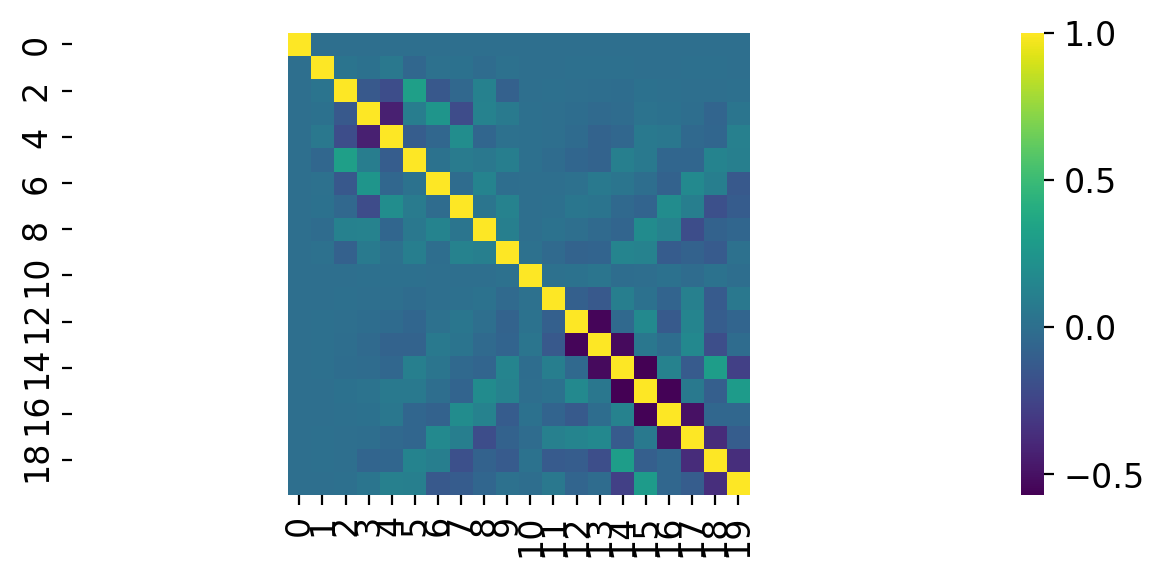

In [359]:
corr = bel_final.cov
corr = jnp.einsum("ij,ii,jj->ij", corr, 1/jnp.sqrt(corr), 1/jnp.sqrt(corr))
plt.axis("equal")
sns.heatmap(corr, cmap="viridis")

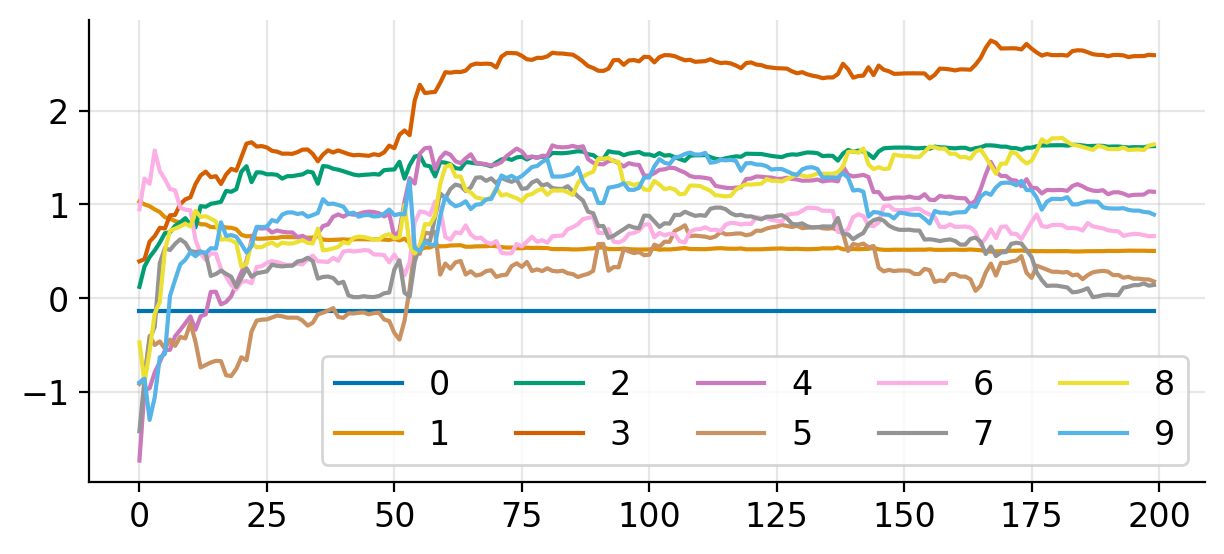

In [360]:
for i in range(10):
    plt.plot(hist_online["mu"][:, i], label=i)
plt.legend(ncol=5)
plt.grid(alpha=0.3)

In [361]:
jnp.sqrt(jnp.power(sample["y"] - hist_online["yhat"], 2).mean())

Array(1.9877981, dtype=float32)

In [362]:
jnp.sqrt(jnp.power(sample["y"] - hist_optimal["yhat"], 2).mean())

Array(1.6525016, dtype=float32)

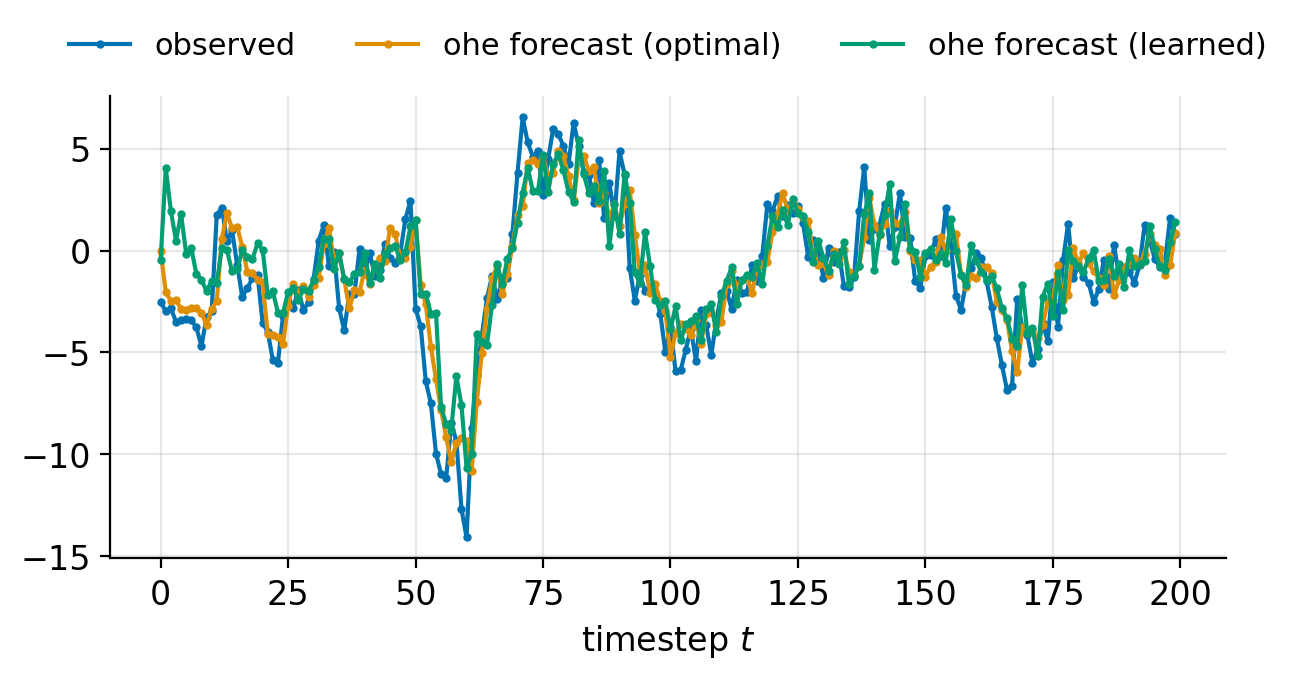

In [363]:
markersize = 0
plt.plot(sample["y"], marker="o", markersize=2, label="observed")
plt.plot(hist_optimal["yhat"], marker="o", markersize=2, label="ohe forecast (optimal)")
plt.plot(hist_online["yhat"], marker="o", markersize=2, label="ohe forecast (learned)")
plt.legend(ncol=3, loc="upper center", bbox_to_anchor=(0.5, 1.2), frameon=False, fontsize=11)
plt.xlabel("timestep $t$")
plt.grid(alpha=0.3)

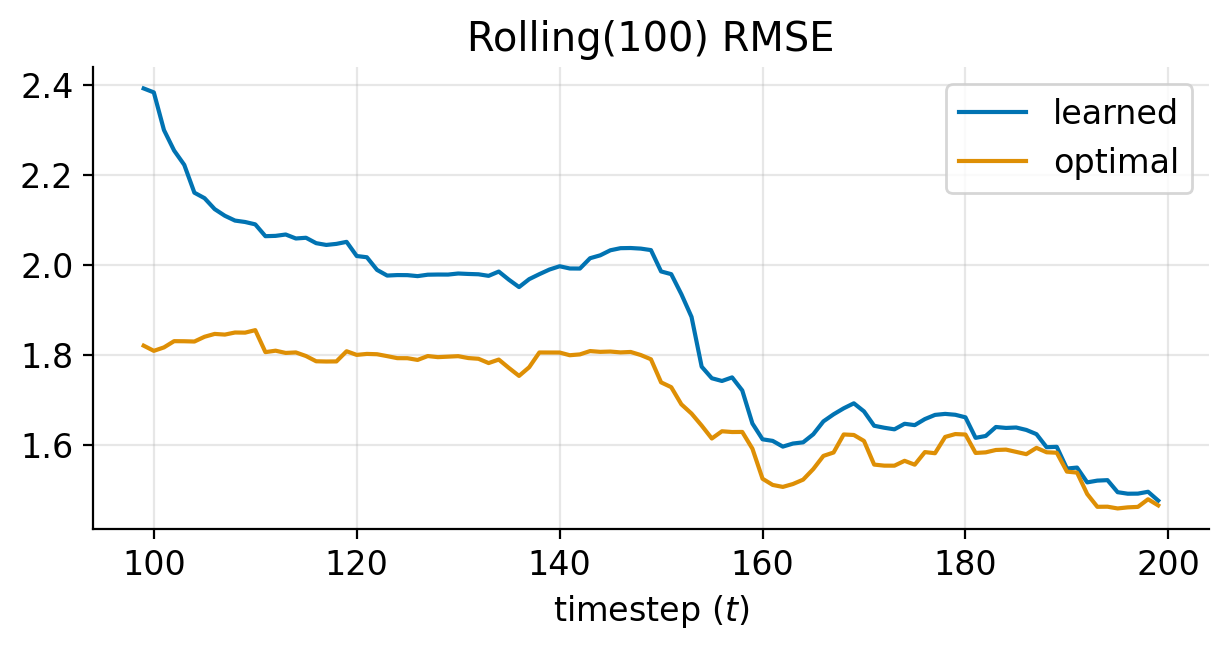

In [373]:
rmse_online = np.sqrt(pd.Series(jnp.power(sample["y"] - hist_online["yhat"], 2)).rolling(100).mean())
rmse_optimal = np.sqrt(pd.Series(jnp.power(sample["y"] - hist_optimal["yhat"], 2)).rolling(100).mean())

plt.plot(rmse_online, label="learned")
plt.plot(rmse_optimal, label="optimal")
plt.legend()
plt.title("Rolling(100) RMSE")
plt.xlabel("timestep ($t$)")
plt.grid(alpha=0.3)

In [364]:
jnp.corrcoef(sample["y"], hist_optimal["yhat"])[0,1]

Array(0.87809455, dtype=float32)

In [365]:
jnp.corrcoef(sample["y"], hist_online["yhat"])[0,1]

Array(0.8300547, dtype=float32)

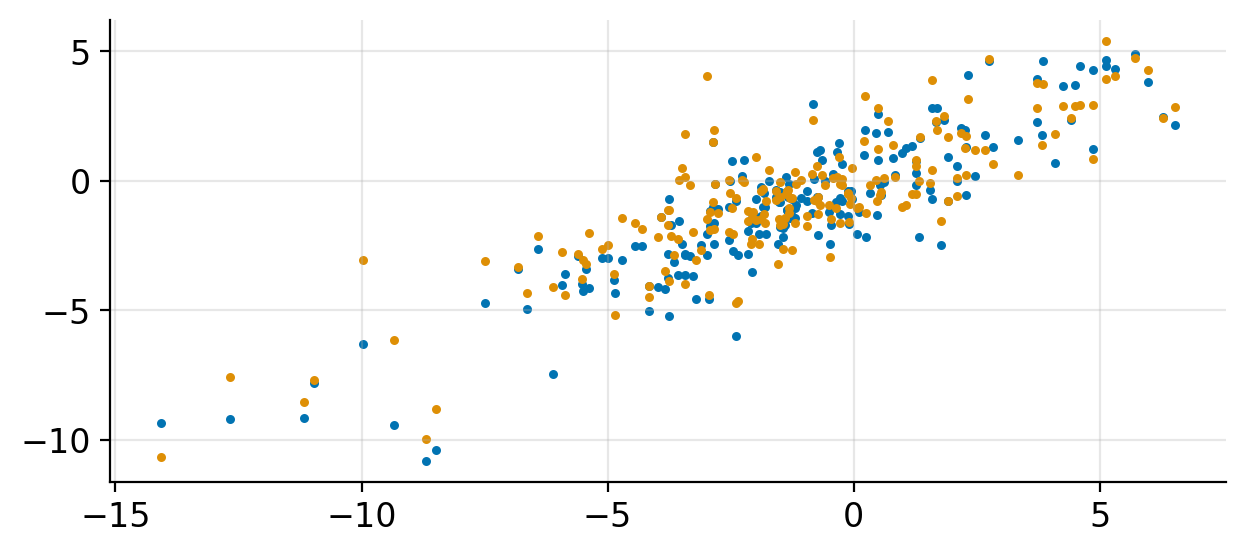

In [367]:
markersize = 5
plt.scatter(sample["y"], hist_optimal["yhat"], s=markersize)
plt.scatter(sample["y"], hist_online["yhat"], s=markersize)
plt.grid(alpha=0.3)

# References
* Bell, Bradley M., and Frederick W. Cathey. "The iterated Kalman filter update as a Gauss-Newton method." IEEE Transactions on Automatic Control 38.2 (1993): 294-297.